In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, ExtraTreesClassifier,GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, KFold
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import xgboost

import warnings
warnings.filterwarnings("ignore")

C:\Users\Paradise\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
df_train = pd.read_csv('train.csv', header=0)
df_test = pd.read_csv('test.csv',header=0)
print(df_train.shape, df_train.columns)
df_train.head()

(116058, 29) Index(['loan_id', 'source', 'financial_institution', 'interest_rate',
       'unpaid_principal_bal', 'loan_term', 'origination_date',
       'first_payment_date', 'loan_to_value', 'number_of_borrowers',
       'debt_to_income_ratio', 'borrower_credit_score', 'loan_purpose',
       'insurance_percent', 'co-borrower_credit_score', 'insurance_type', 'm1',
       'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12',
       'm13'],
      dtype='object')


,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,...,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13
0,268055008619,Z,"Turner, Baldwin and Rhodes",4.250,214000,360,2012-03-01,05/2012,95,1.0,...,0,0,0,1,0,0,0,0,0,1
1,672831657627,Y,"Swanson, Newton and Miller",4.875,144000,360,2012-01-01,03/2012,72,1.0,...,0,0,0,0,0,0,0,1,0,1
2,742515242108,Z,Thornton-Davis,3.250,366000,180,2012-01-01,03/2012,49,1.0,...,0,0,0,0,0,0,0,0,0,1
3,601385667462,X,OTHER,4.750,135000,360,2012-02-01,04/2012,46,2.0,...,0,0,0,0,0,1,1,1,1,1
4,273870029961,X,OTHER,4.750,124000,360,2012-02-01,04/2012,80,1.0,...,3,4,5,6,7,8,9,10,11,1


In [4]:
df_train_0 = df_train[df_train['m13'] == 0]
df_train_1 = df_train[df_train['m13'] == 1]

In [5]:
df_train = pd.get_dummies(df_train, columns=['source', 'financial_institution', 'loan_purpose'])
df_train['origination_date'] = pd.to_datetime(df_train['origination_date'], format="%Y/%m/%d")
df_train['first_payment_date'] = pd.to_datetime(df_train['first_payment_date'], format="%m/%Y")
df_train['term'] = df_train['loan_term'].astype('timedelta64[ns]')
df_train['day'] = df_train['first_payment_date'] - df_train['origination_date']
df_train['app'] = df_train['day'] / df_train['term']
df_train['app'] = df_train['app'].astype('float')

In [6]:
df_train.isnull().sum().sum()


0

In [7]:
df_train['m13'].value_counts()

0    115422
1       636
Name: m13, dtype: int64

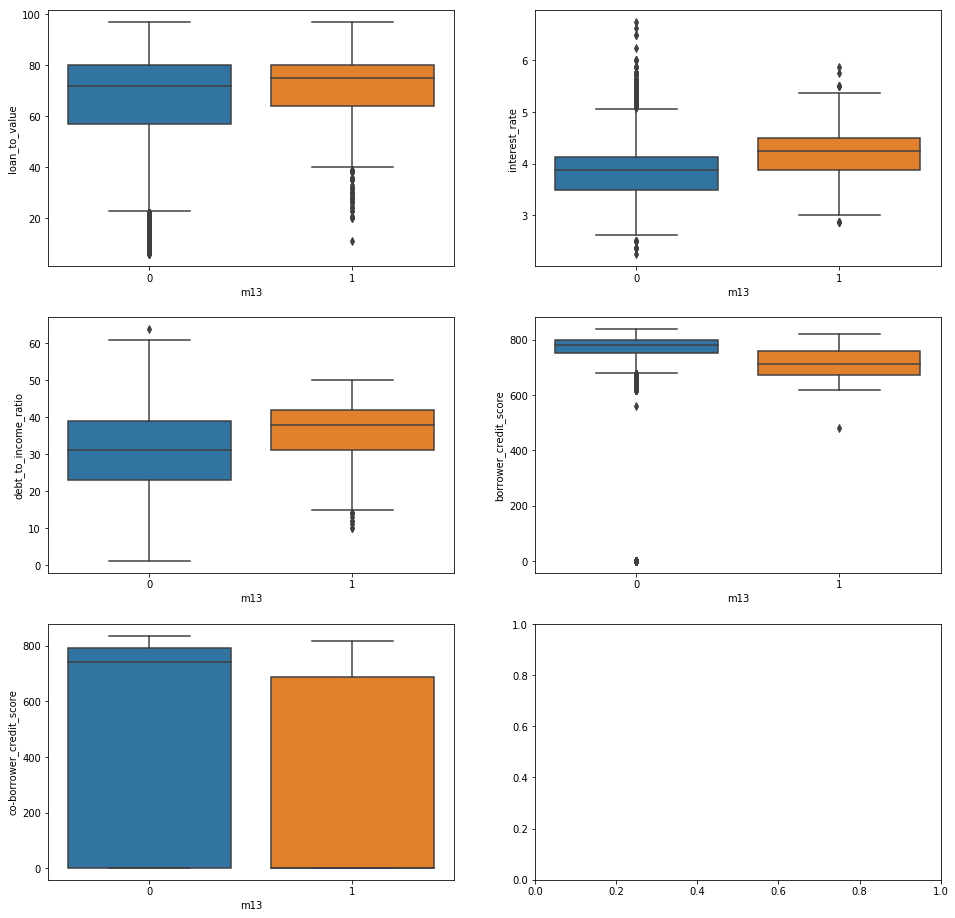

In [8]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(16,16))
AX = [ax1, ax2, ax3, ax4, ax5, ax6]
sns.boxplot(x = df_train['m13'], y = df_train['loan_to_value'],ax=ax1)
sns.boxplot(x = df_train['m13'], y = df_train['interest_rate'],ax=ax2)
sns.boxplot(x = df_train['m13'], y = df_train['debt_to_income_ratio'],ax=ax3)
sns.boxplot(x = df_train['m13'], y = df_train['borrower_credit_score'],ax=ax4)
sns.boxplot(x = df_train['m13'], y = df_train['co-borrower_credit_score'],ax=ax5)

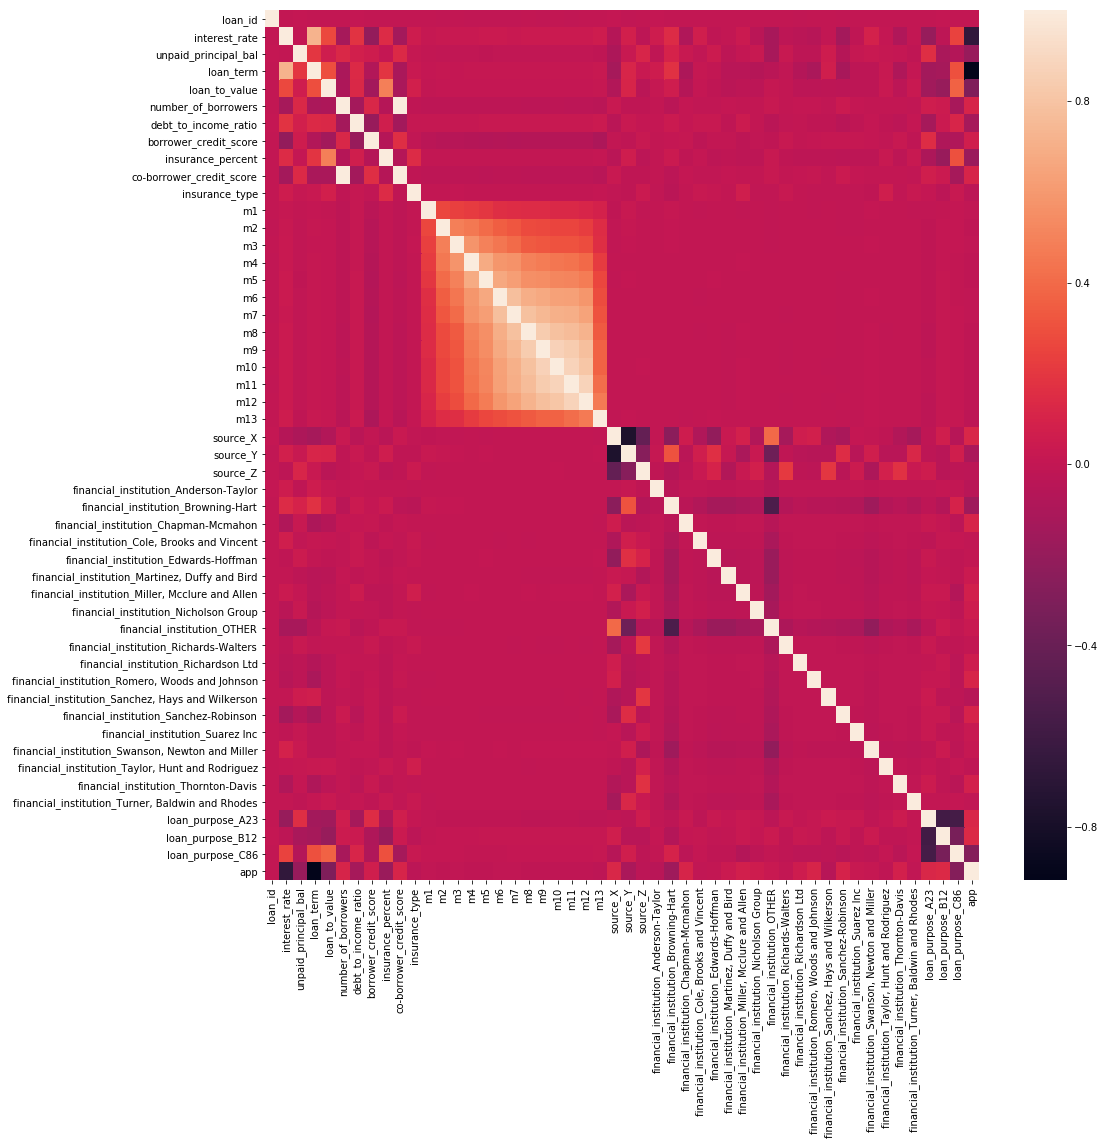

In [10]:
# Correlation matrix
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(df_train.corr())

In [13]:
downsample = 55
oversample = 2.5
df_train_0_1 = df_train_0[:downsample*len(df_train_1)]
df_train_0_2 = df_train_0[downsample*len(df_train_1):2*downsample*len(df_train_1)]
df_train_0_3 = df_train_0[2*downsample*len(df_train_1):3*downsample*len(df_train_1)]
df_train_0_4 = df_train_0[3*downsample*len(df_train_1):]
df_train_1 = df_train_1.sample(int(oversample*len(df_train_1)), replace=True)

In [14]:
df = pd.concat([df_train_1, df_train_0_1])
df_1 = pd.concat([df_train_1, df_train_0_2])
df_2 = pd.concat([df_train_1, df_train_0_3])
df_3 = pd.concat([df_train_1, df_train_0_4])

In [15]:
def Model(df, flag, mdel):
    df = pd.get_dummies(df, columns=['source', 'financial_institution', 'loan_purpose'])
    df['origination_date'] = pd.to_datetime(df['origination_date'], format="%Y/%m/%d")
    df['first_payment_date'] = pd.to_datetime(df['first_payment_date'], format="%m/%Y")
    df['term'] = df['loan_term'].astype('timedelta64[ns]')
    df['day'] = df['first_payment_date'] - df['origination_date']
    df['app'] = df['day'] / df['term']
    df['app'] = df['app'].astype('float')

    y = df['m13']
    x = df.drop(columns=['m13', 'loan_id', 'origination_date', 'first_payment_date', 'day', 'term'])

    x_train, x_cv, y_train, y_cv = train_test_split(x, y, test_size=0.3)

    dt = DecisionTreeClassifier(max_depth=21,
                                min_samples_split=2,
                                max_features=None,
                                random_state=None,
                                max_leaf_nodes=None,
                                )
    if flag:
        model = xgboost.XGBClassifier(base_estimator=dt, n_estimators=500, xgb_model=mdel,scale_pos_weight=4)
    else:
        model = xgboost.XGBClassifier(base_estimator=dt, n_estimators=500, scale_pos_weight=4)

    model.fit(x_train, y_train)
    y_pred = model.predict(x_cv)

    print(classification_report(y_cv, y_pred))

    return model

In [16]:
model_1 = Model(df, False, None)
model_2 = Model(df_1, True, model_1)
model_3 = Model(df_2, True, model_2)
model_4 = Model(df_3, True, model_3)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10507
           1       0.85      0.69      0.76       464

    accuracy                           0.98     10971
   macro avg       0.92      0.84      0.88     10971
weighted avg       0.98      0.98      0.98     10971

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     10499
           1       0.87      0.69      0.77       472

    accuracy                           0.98     10971
   macro avg       0.93      0.84      0.88     10971
weighted avg       0.98      0.98      0.98     10971

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10479
           1       0.87      0.73      0.79       492

    accuracy                           0.98     10971
   macro avg       0.93      0.86      0.89     10971
weighted avg       0.98      0.98      0.98     10971



In [17]:
df_test = pd.get_dummies(df_test, columns=['source', 'financial_institution', 'loan_purpose'])
df_test['origination_date'] = pd.to_datetime(df_test['origination_date'], format="%d/%m/%y")
df_test['first_payment_date'] = pd.to_datetime(df_test['first_payment_date'], format="%b-%y")
df_test['term'] = df_test['loan_term'].astype('timedelta64[ns]')
df_test['day'] = df_test['first_payment_date'] - df_test['origination_date']
df_test['app'] = df_test['day']/df_test['term']
df_test['app'] = df_test['app'].astype('float')
df_test.drop(columns=['loan_id', 'origination_date', 'first_payment_date', 'day', 'term'], inplace=True)

y = model_3.predict(df_test)
df_test['m13'] = y
df_test = df_test[['m13']]
df_test['loan_id'] = df_test.index + 1

df_test.to_csv('final_submission.csv', index=False)


In [20]:
col = df_train.drop(columns=['m13', 'loan_id', 'origination_date', 'first_payment_date', 'day', 'term']).tolist()
col.append('app')
feat_importance = pd.Series(model_3.feature_importances_, index=col)
feat_importance.nlargest(30).plot(kind='barh')

AttributeError: 'DataFrame' object has no attribute 'tolist'